In [2]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

Akarshs-MacBook-Pro.local
/Users/akarshkumar0101/spaghetti/src_pb
/Users/akarshkumar0101/miniconda3/bin/python


In [3]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
from cppn import CPPN, FlattenCPPNParameters
import util
from viz import viz_feature_maps

```bash
python process_pb.py --zip_path="/home/akarsh_sakana_ai/spaghetti-data/pb_data/4376/rep.zip" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/butterfly"
python process_pb.py --zip_path="/home/akarsh_sakana_ai/spaghetti-data/pb_data/576/rep.zip" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/skull"
python process_pb.py --zip_path="/home/akarsh_sakana_ai/spaghetti-data/pb_data/5736/rep.zip" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/apple"
python process_pb.py --zip_path="/home/akarsh_sakana_ai/spaghetti-data/pb_data/613/rep.zip" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/clown"
python process_pb.py --zip_path="/home/akarsh_sakana_ai/spaghetti-data/pb_data/395/rep.zip" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/spotlight"
```

```bash
python process_pb.py --zip_path="/Users/akarshkumar0101/spaghetti_old/spaghetti/pbRender/genomeAll/576/rep.zip" --save_dir="/Users/akarshkumar0101/spaghetti-data/skull"
```


skull:
(12, 'cache:15,gaussian:4,identity:2,sin:1')
ParameterReshaper: 5478 parameters detected for optimization.


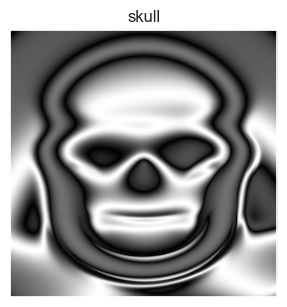

In [6]:
# names = ['butterfly', 'skull', 'apple', 'clown', 'spotlight']
names = ['skull']
name2cppn_args = dict()
plt.figure(figsize=(20, 5))
for i, name in enumerate(names):
    # save_dir = f"/home/akarsh_sakana_ai/spaghetti-data/{name}"
    save_dir = f"/Users/akarshkumar0101/spaghetti-data/{name}"
    outputs = util.load_pkl(save_dir, "outputs")
    params = util.load_pkl(save_dir, "params")
    cppn_args = util.load_pkl(save_dir, "cppn_args")

    print()
    print(f"{name}:")
    print(cppn_args)
    name2cppn_args[name] = cppn_args

    cppn = CPPN(*cppn_args)
    cppn = FlattenCPPNParameters(cppn)
    img, features = cppn.generate_image(params, return_features=True)
    plt.subplot(1, 5, i+1)
    plt.title(f"{name}")
    plt.imshow(img); plt.xticks([]); plt.yticks([])

plt.show()

In [7]:
for name, cppn_args in name2cppn_args.copy().items():
    n_layers, arch = cppn_args
    name2cppn_args[f"{name}_sgd"] = (n_layers, arch)
    d_hidden = sum([int(s.split(":")[-1]) for s in arch.split(",")])
    name2cppn_args[f"{name}_sgd_relu"] = (n_layers, f"relu:{d_hidden}")

In [8]:
for name, cppn_args in name2cppn_args.items():
    n_layers, arch = cppn_args
    # print(name, cppn_args)
    name_pb = name.split("_")[0]
    # print(name_pb)
    command = f'python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/{name_pb}/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/{name}" --n_layers={n_layers} --arch="{arch}" --n_iters=100000'
    if "sgd" in name:
        print(command)

python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/skull/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/skull_sgd" --n_layers=12 --arch="cache:15,gaussian:4,identity:2,sin:1" --n_iters=100000
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/skull/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/skull_sgd_relu" --n_layers=12 --arch="relu:22" --n_iters=100000


ParameterReshaper: 5478 parameters detected for optimization.


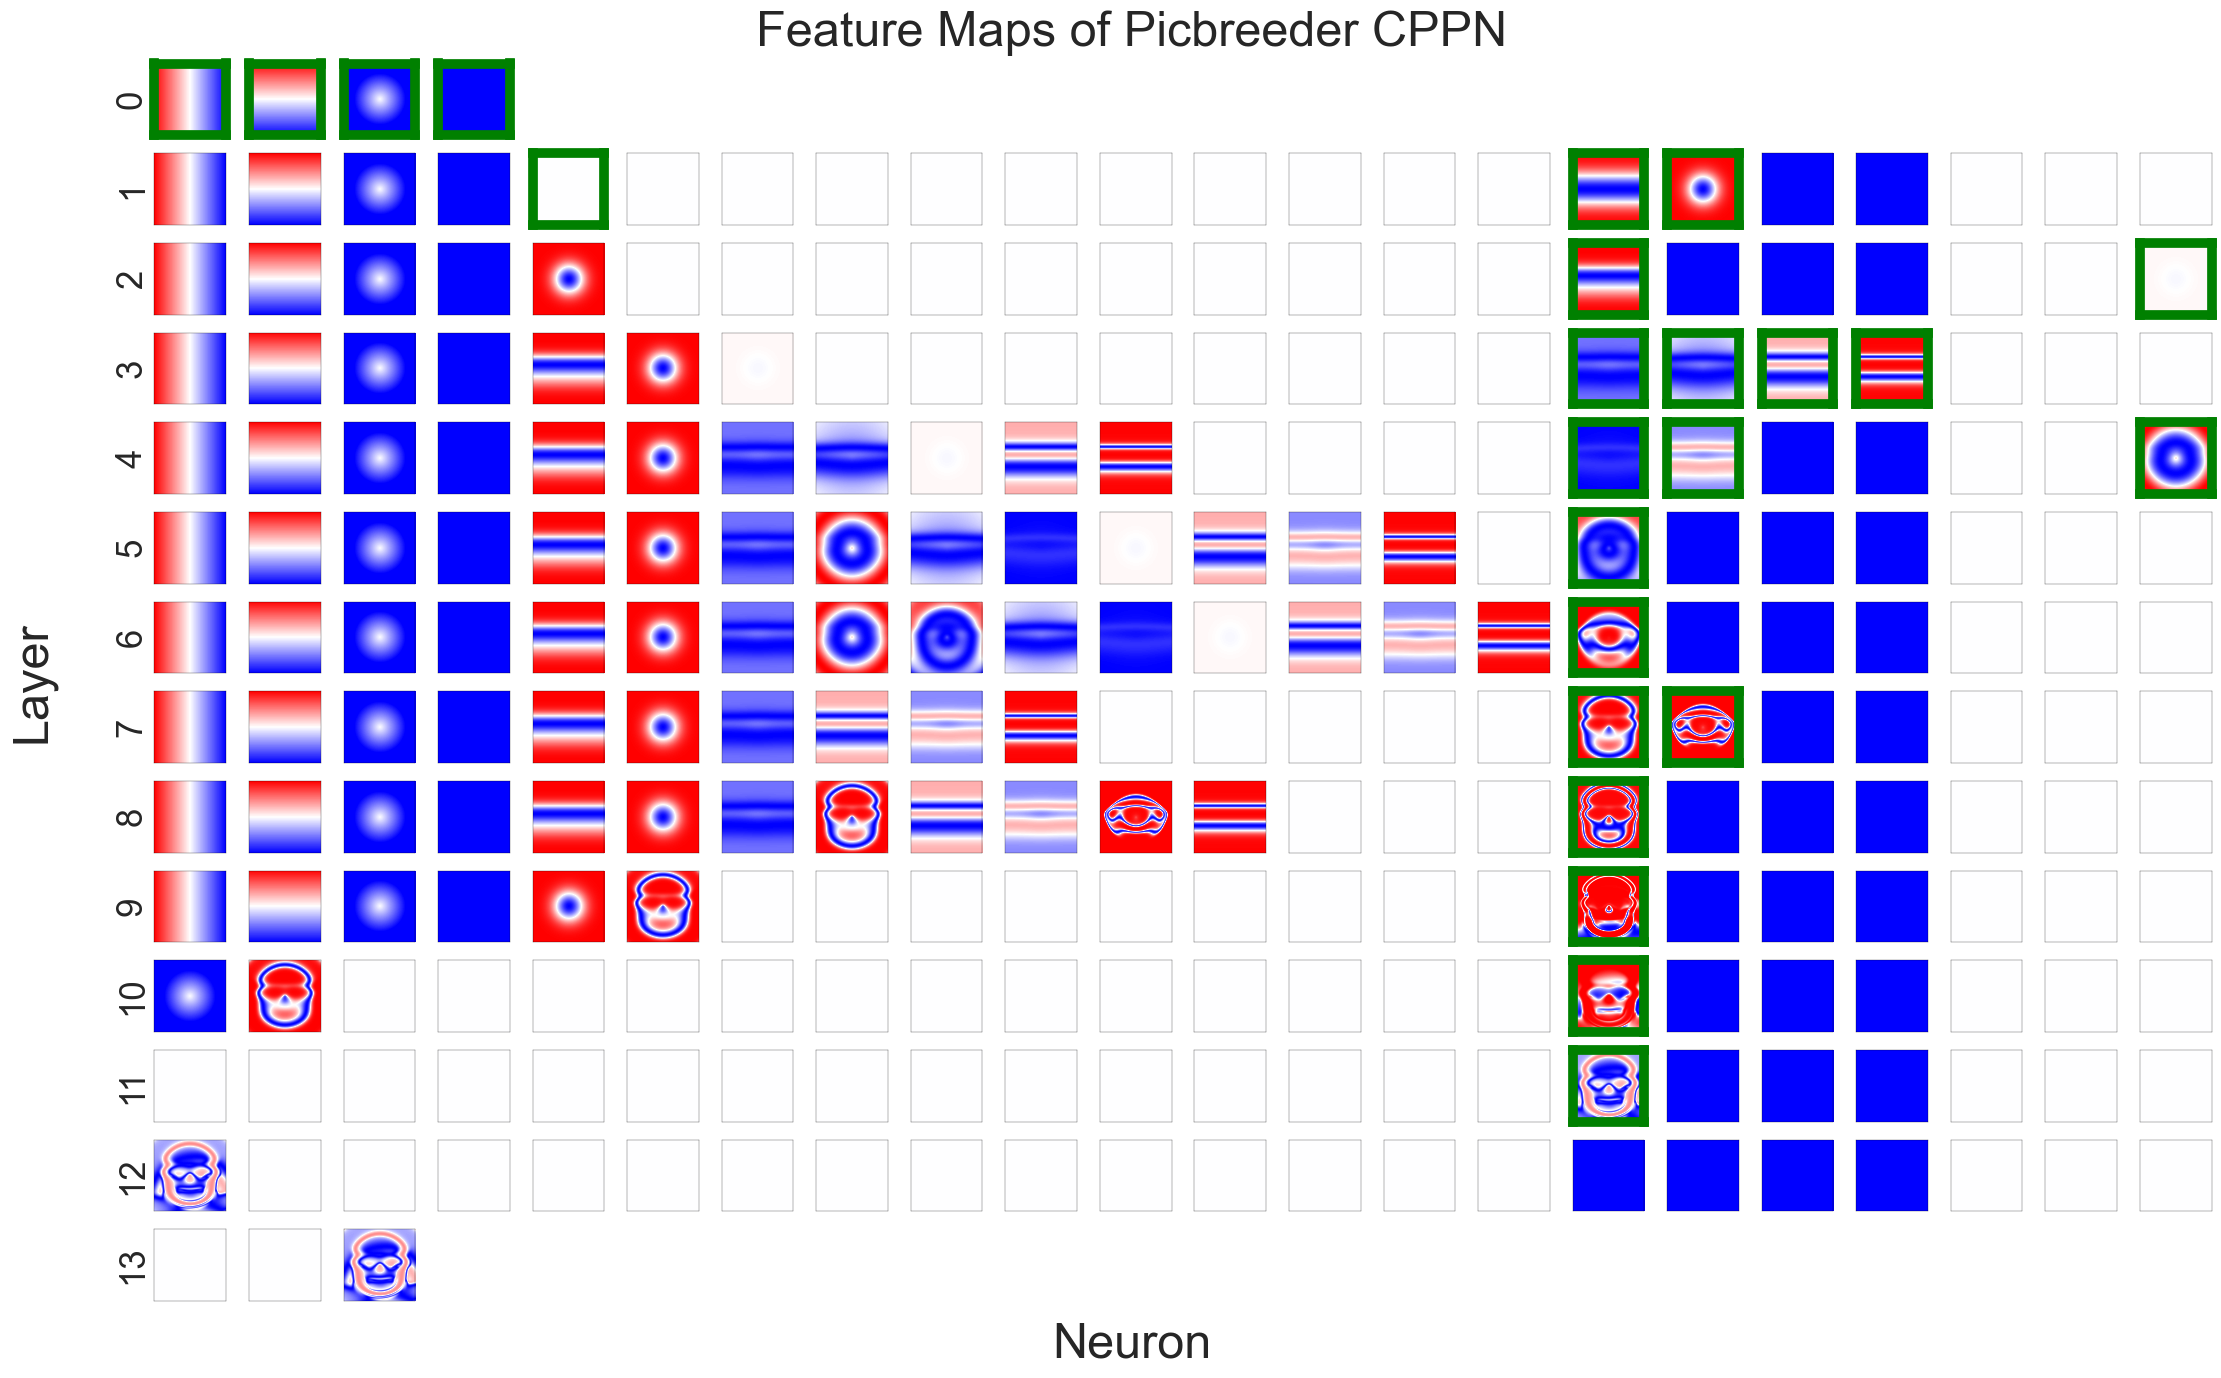

In [35]:
name = "skull"
cppn_args = name2cppn_args[name]
save_dir = f"/Users/akarshkumar0101/spaghetti-data/{name}"
params = util.load_pkl(save_dir, "params")
cppn = CPPN(*cppn_args)
cppn = FlattenCPPNParameters(cppn)

# img, features = cppn.generate_image(params, return_features=True)
# plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.title(f"{name}", fontsize=30)
# plt.show()

viz_feature_maps(features); plt.suptitle("Feature Maps of Picbreeder CPPN", fontsize=35)
plt.show()

In [7]:
for name, cppn_args in name2cppn_args.items():
    print(name)
    save_dir = f"/home/akarsh_sakana_ai/spaghetti-data/{name}"
    # outputs = util.load_pkl(save_dir, "outputs")
    params = util.load_pkl(save_dir, "params")
    # cppn_args = util.load_pkl(save_dir, "cppn_args")
    # print(name)
    cppn = CPPN(*cppn_args)
    cppn = FlattenCPPNParameters(cppn)

    img, features = cppn.generate_image(params, return_features=True)
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.title(f"{name}", fontsize=30)
    plt.savefig(f"{save_dir}/img_output.png", bbox_inches="tight")
    plt.close()

    viz_feature_maps(features); plt.suptitle("Feature Maps of Picbreeder CPPN", fontsize=35)
    plt.savefig(f"{save_dir}/feature_maps.png", bbox_inches="tight")
    plt.close()

    if "sgd" in name:
        losses = util.load_pkl(save_dir, "losses")
        imgs_train = util.load_pkl(save_dir, "imgs_train")
        plt.figure(figsize=(20, 10))
        plt.subplot(211)
        plt.plot(losses); plt.yscale('log'); plt.xlabel("Iteration", fontsize=30); plt.ylabel("Loss", fontsize=30)
        plt.subplot(212)
        imgs = imgs_train[:30]; imgs = rearrange(imgs, "(C R) H W D -> (R H) (C W) D", R=2)
        plt.imshow(imgs); plt.grid(False); plt.xticks([]); plt.yticks([])
        plt.title("Images over SGD Training", fontsize=30)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/sgd_training.png", bbox_inches="tight")
        plt.close()


butterfly
ParameterReshaper: 8096 parameters detected for optimization.
skull
ParameterReshaper: 5478 parameters detected for optimization.
butterfly_sgd
ParameterReshaper: 8096 parameters detected for optimization.
butterfly_sgd_relu
ParameterReshaper: 8096 parameters detected for optimization.
skull_sgd
ParameterReshaper: 5478 parameters detected for optimization.
skull_sgd_relu
ParameterReshaper: 5478 parameters detected for optimization.


(16, 'cache:17,gaussian:4,sigmoid:1,sin:1')
ParameterReshaper: 8096 parameters detected for optimization.


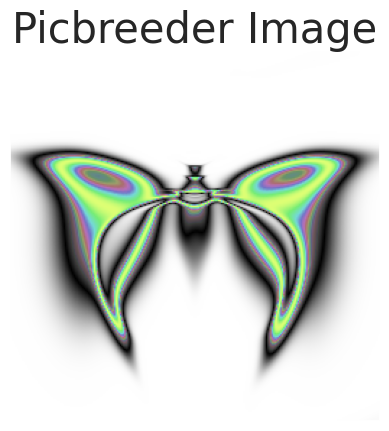

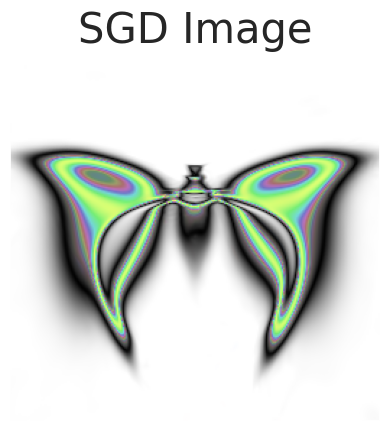

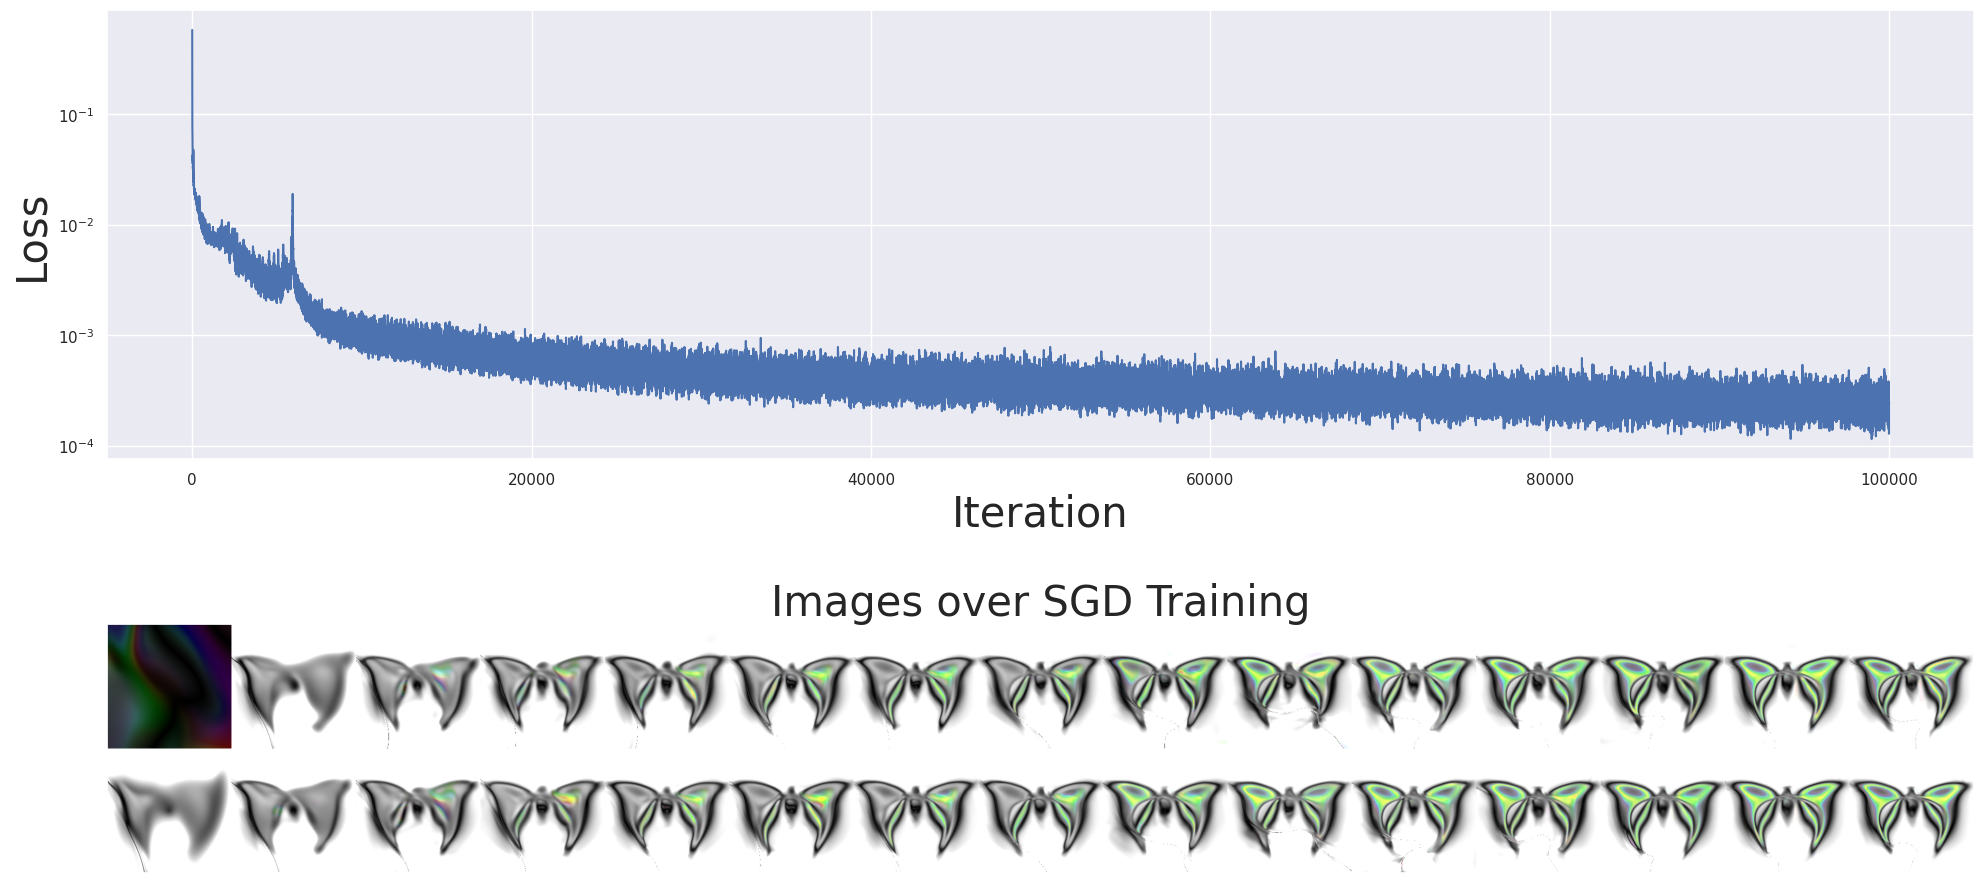

In [ ]:
for pbname in ["butterfly"]:
    save_dir = f"/home/akarsh_sakana_ai/spaghetti-data/{pbname}"
    outputs = util.load_pkl(save_dir, "outputs")
    params = util.load_pkl(save_dir, "params")
    cppn_args = util.load_pkl(save_dir, "cppn_args")
    print(cppn_args)
    cppn = CPPN(*cppn_args)
    cppn = FlattenCPPNParameters(cppn)


    save_dir_sgd = f"/home/akarsh_sakana_ai/spaghetti-data/{pbname}_sgd"
    params_sgd = util.load_pkl(save_dir_sgd, "params")
    losses = util.load_pkl(save_dir_sgd, "losses")
    imgs_train = util.load_pkl(save_dir_sgd, "imgs_train")

    img, features = cppn.generate_image(params, return_features=True)
    img_sgd, features_sgd = cppn.generate_image(params_sgd, return_features=True)

    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.title("Picbreeder Image", fontsize=30)
    plt.show()
    plt.imshow(img_sgd); plt.xticks([]); plt.yticks([]); plt.title("SGD Image", fontsize=30)
    plt.show()

    plt.figure(figsize=(20, 10))
    plt.subplot(211)
    plt.plot(losses); plt.yscale('log'); plt.xlabel("Iteration", fontsize=30); plt.ylabel("Loss", fontsize=30)
    plt.subplot(212)
    imgs = imgs_train[:30]; imgs = rearrange(imgs, "(C R) H W D -> (R H) (C W) D", R=2)
    plt.imshow(imgs); plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.title("Images over SGD Training", fontsize=30)
    plt.tight_layout()
    plt.show()


    viz_feature_maps(features); plt.suptitle("Feature Maps of Picbreeder CPPN", fontsize=35)
    plt.show()
    viz_feature_maps(features_sgd); plt.suptitle("Feature Maps of SGD CPPN", fontsize=35)
    plt.show()
    break




In [18]:
save_dir = "/home/akarsh_sakana_ai/spaghetti-data/butterfly"
params = util.load_pkl(save_dir, "params")
# cppn = CPPN(12, "relu:22")
# cppn = CPPN(16, "relu:23")
# cppn = FlattenCPPNParameters(cppn)
img, features = cppn.generate_image(params, return_features=True)

In [19]:
len(params)

8096

In [20]:
((params!=0) & (params!=1)).sum()

Array(104, dtype=int32)

In [21]:
gen_img_fn = jax.jit(jax.vmap(cppn.generate_image))

def sweep_weight(params, weight_id, center_weight=True, r=1, n=11, ret="variance"):
    weight_sweep = jnp.linspace(-r, r, n)
    if center_weight:
        weight_sweep = weight_sweep + params[weight_id]
    params_p = repeat(params, "p -> n p", n=n).at[:, weight_id].set(weight_sweep)
    imgs = gen_img_fn(params_p)
    if ret=="imgs":
        return imgs
    elif ret=="variance":
        variance = jnp.var(imgs, axis=0).mean()
        return variance
    raise ValueError("Invalid ret")


In [22]:
# variances = jax.lax.map(partial(get_variance, params), jnp.arange(0, len(params), 1), batch_size=20)
weight_ids = jnp.where((params!=0) & (params!=1))[0]
variances = jax.lax.map(partial(sweep_weight, params, center_weight=True, r=1, ret="variance"), weight_ids, batch_size=20)

In [36]:
for weight_id in weight_ids[jnp.argsort(variances)][::-1][:60]:
    imgs = sweep_weight(params, weight_id, center_weight=True, r=1, ret="imgs")
    # params_p = repeat(params, "p -> n p", n=11).at[:, weight_id].set(weight_sweep)
    # imgs = gen_img_fn(params_p)
    imgs = np.pad(imgs, ((0, 0), (5, 5), (5, 5), (0, 0)), mode='constant', constant_values=0)
    imgs = rearrange(imgs, "n H W D -> H (n W) D")
    plt.figure(figsize=(20, 2))
    plt.imshow(imgs); plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.suptitle(f"Sweeping Weight ID: {weight_id.item()} (Original Value = {params[weight_id].item():.2f})", fontsize=20)
    plt.show()

NameError: name 'weight_ids' is not defined

In [ ]:
# 4, 50
cppn = CPPN(10, 25, nonlins="identity,sin,cos,gaussian,sigmoid")
cppn = FlattenCPPNParameters(cppn)

save_dir = "../temp_dir"
losses = util.load_pkl(save_dir, "losses")
imgs_train = util.load_pkl(save_dir, "imgs_train")
params = util.load_pkl(save_dir, "params")

ParameterReshaper: 6028 parameters detected for optimization.


In [16]:
imgs_train.shape, losses.shape

((501, 256, 256, 3), (50000,))

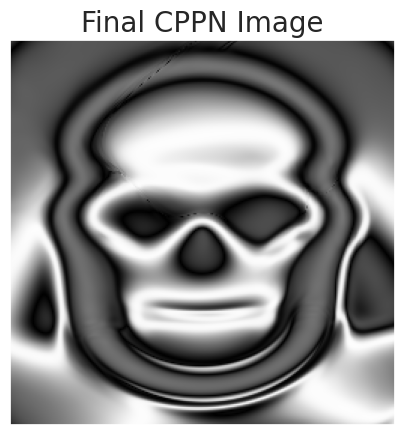

In [17]:
plt.figure(figsize=(5, 5))
img = cppn.generate_image(params)
plt.imshow(img); plt.grid(False); plt.xticks([]); plt.yticks([])
plt.title("Final CPPN Image", fontsize=20)
plt.show()

(512, 2560, 3)


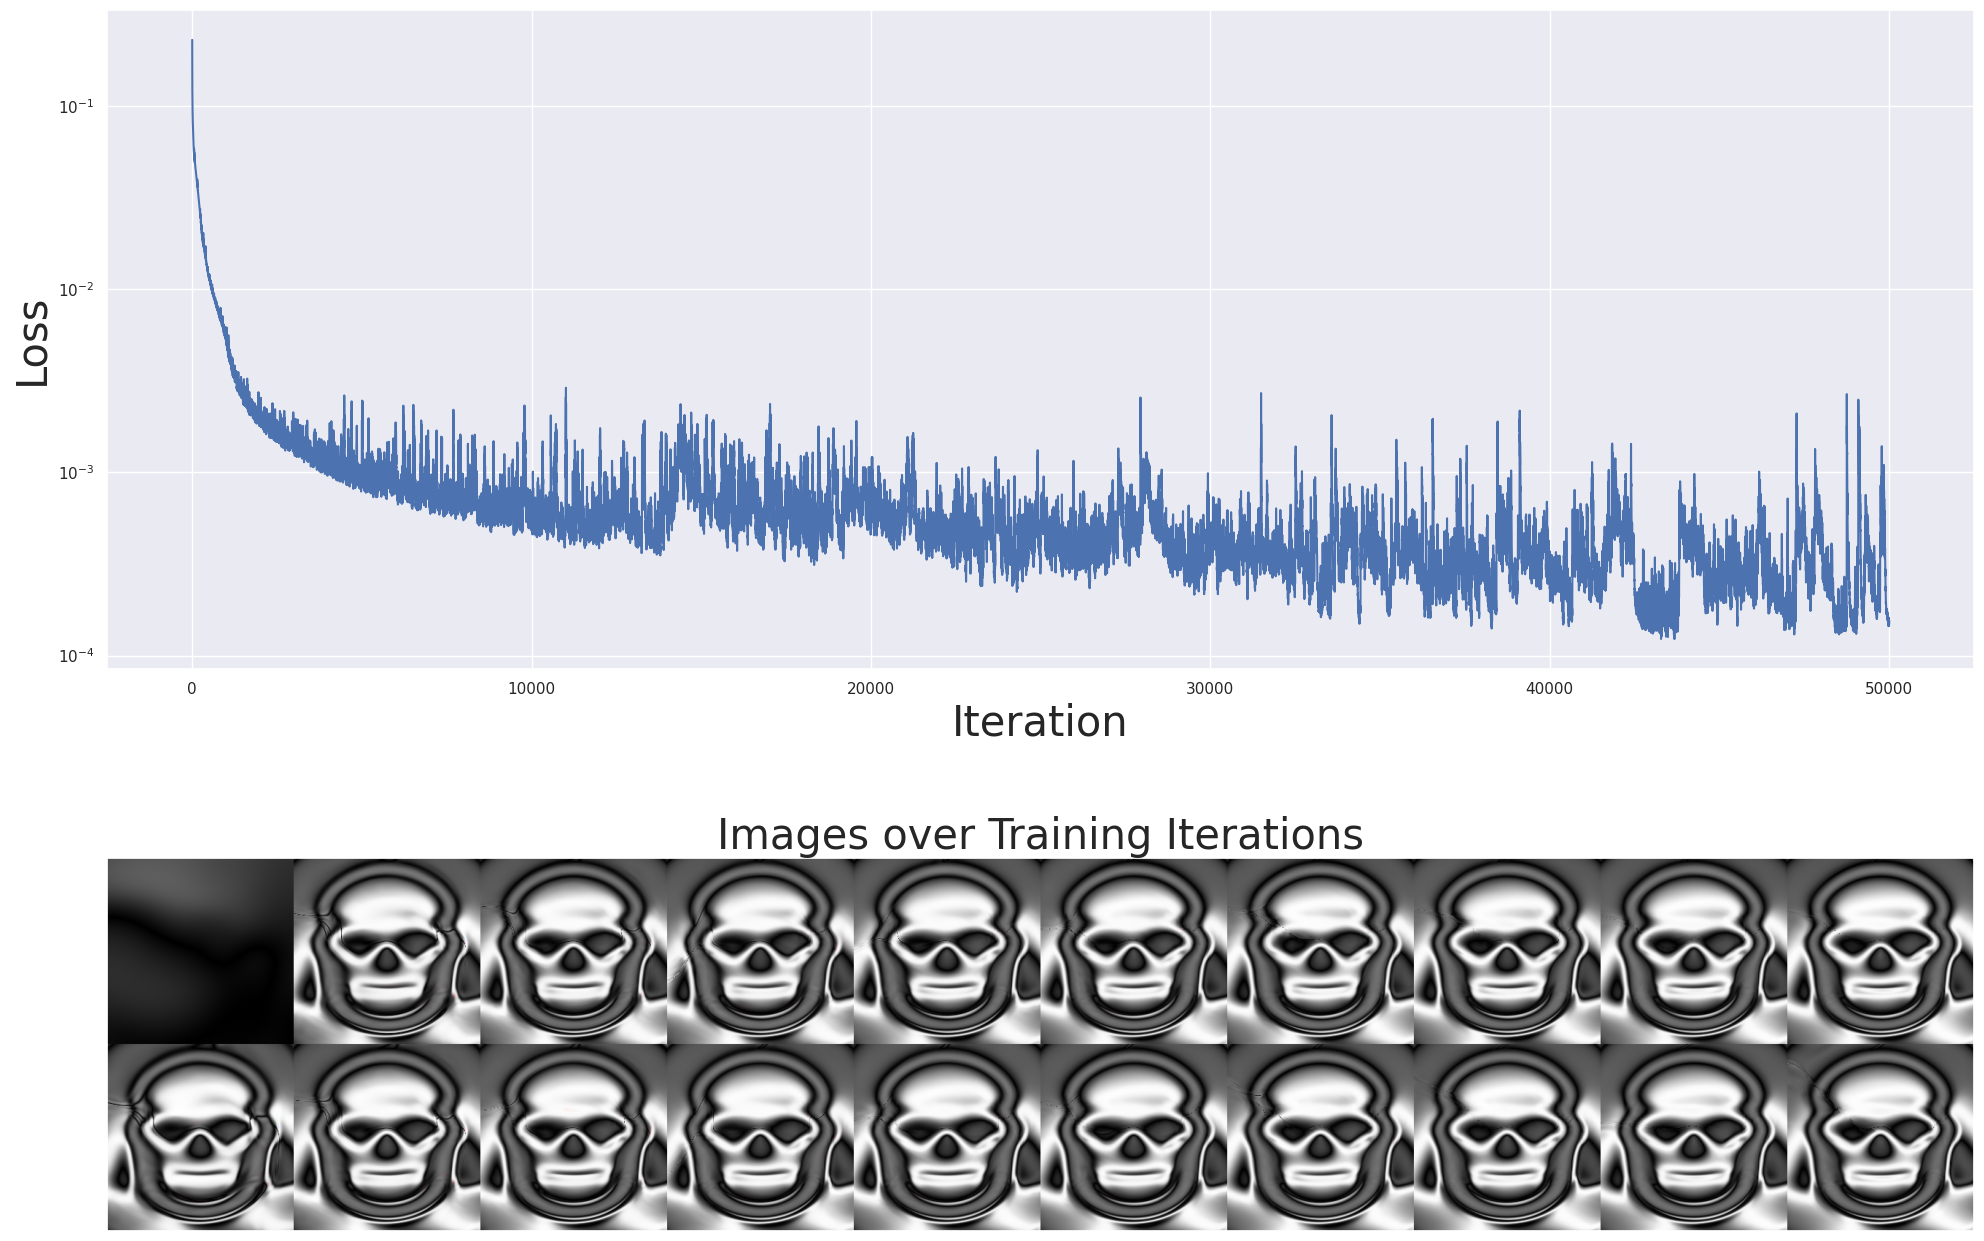

In [18]:
plt.figure(figsize=(20, 14))
plt.subplot(211)
plt.plot(losses)
plt.yscale('log')
plt.xlabel("Iteration", fontsize=30)
plt.ylabel("Loss", fontsize=30)

plt.subplot(212)
imgs = imgs_train[:-1]
imgs = imgs[::len(imgs)//20]
imgs = rearrange(imgs, "(C R) H W D -> (R H) (C W) D", R=2)
print(imgs.shape)
plt.imshow(imgs); plt.grid(False); plt.xticks([]); plt.yticks([])
plt.title("Images over Training Iterations", fontsize=30)

plt.tight_layout()
plt.show()


In [19]:
weight_sweep = jnp.linspace(-5, 5, 11)
gen_img_fn = jax.jit(jax.vmap(cppn.generate_image))

def get_variance(params, weight_id):
    params_p = repeat(params, "p -> n p", n=len(weight_sweep)).at[:, weight_id].set(weight_sweep)
    imgs = gen_img_fn(params_p)
    variance = jnp.var(imgs, axis=0).mean()
    return variance


In [20]:
%%time
variances = jax.lax.map(partial(get_variance, params), jnp.arange(0, len(params), 1), batch_size=20)

CPU times: user 6.78 s, sys: 5.95 s, total: 12.7 s
Wall time: 13 s


(6028,)


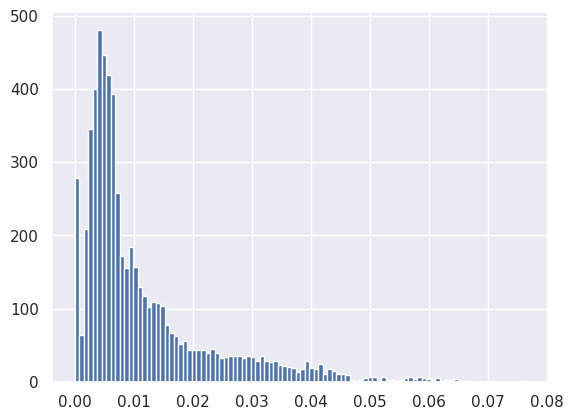

In [21]:
print(variances.shape)
plt.hist(np.array(variances), bins=100)
plt.show()

In [146]:
for weight_id in jnp.argsort(variances)[::-1][:20]:
    params_p = repeat(params, "p -> n p", n=11).at[:, weight_id].set(jnp.linspace(-5, 5, 11))
    imgs = gen_img_fn(params_p)
    imgs = rearrange(imgs, "n H W D -> H (n W) D")
    plt.figure(figsize=(20, 2))
    plt.imshow(imgs); plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.suptitle(f"Sweeping Weight ID: {weight_id.item()} (Original Value = {params[weight_id].item():.2f})", fontsize=20)
    plt.show()

NameError: name 'variances' is not defined

In [36]:
# from matplotlib.colors import LinearSegmentedColormap
# cmap = LinearSegmentedColormap.from_list('red_white_blue', ['red', 'white', 'blue'])
def viz_feature_maps(img, features):
    max_features_per_layer = max(jax.tree.map(lambda x: x.shape[-1], features))
    n_layers = len(features)
    n_layers, max_features_per_layer

    plt.figure(figsize=(1*max_features_per_layer, 1*n_layers))
    for i, layer_features in enumerate(features):
        for j, fmap in enumerate(rearrange(layer_features, 'h w c -> c h w')):
            plt.subplot(n_layers, max_features_per_layer, i*max_features_per_layer + j + 1)
            plt.imshow(fmap, cmap='bwr_r', vmin=-1.0, vmax=1.0); plt.xticks([]); plt.yticks([])
            if j==0:
                plt.ylabel(f"{i}", fontsize=25)
            for spine in plt.gca().spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1)
    # plt.subplot(n_layers, max_features_per_layer, (n_layers-1)*max_features_per_layer + (max_features_per_layer-1) + 1)
    # plt.imshow(rgb); plt.axis('off')
    plt.gcf().supylabel("Layer", fontsize=35)
    plt.gcf().supxlabel("Feature Map", fontsize=35)
    plt.suptitle("Feature Maps of CPPN", fontsize=35)
    plt.tight_layout()
    return plt.gcf()

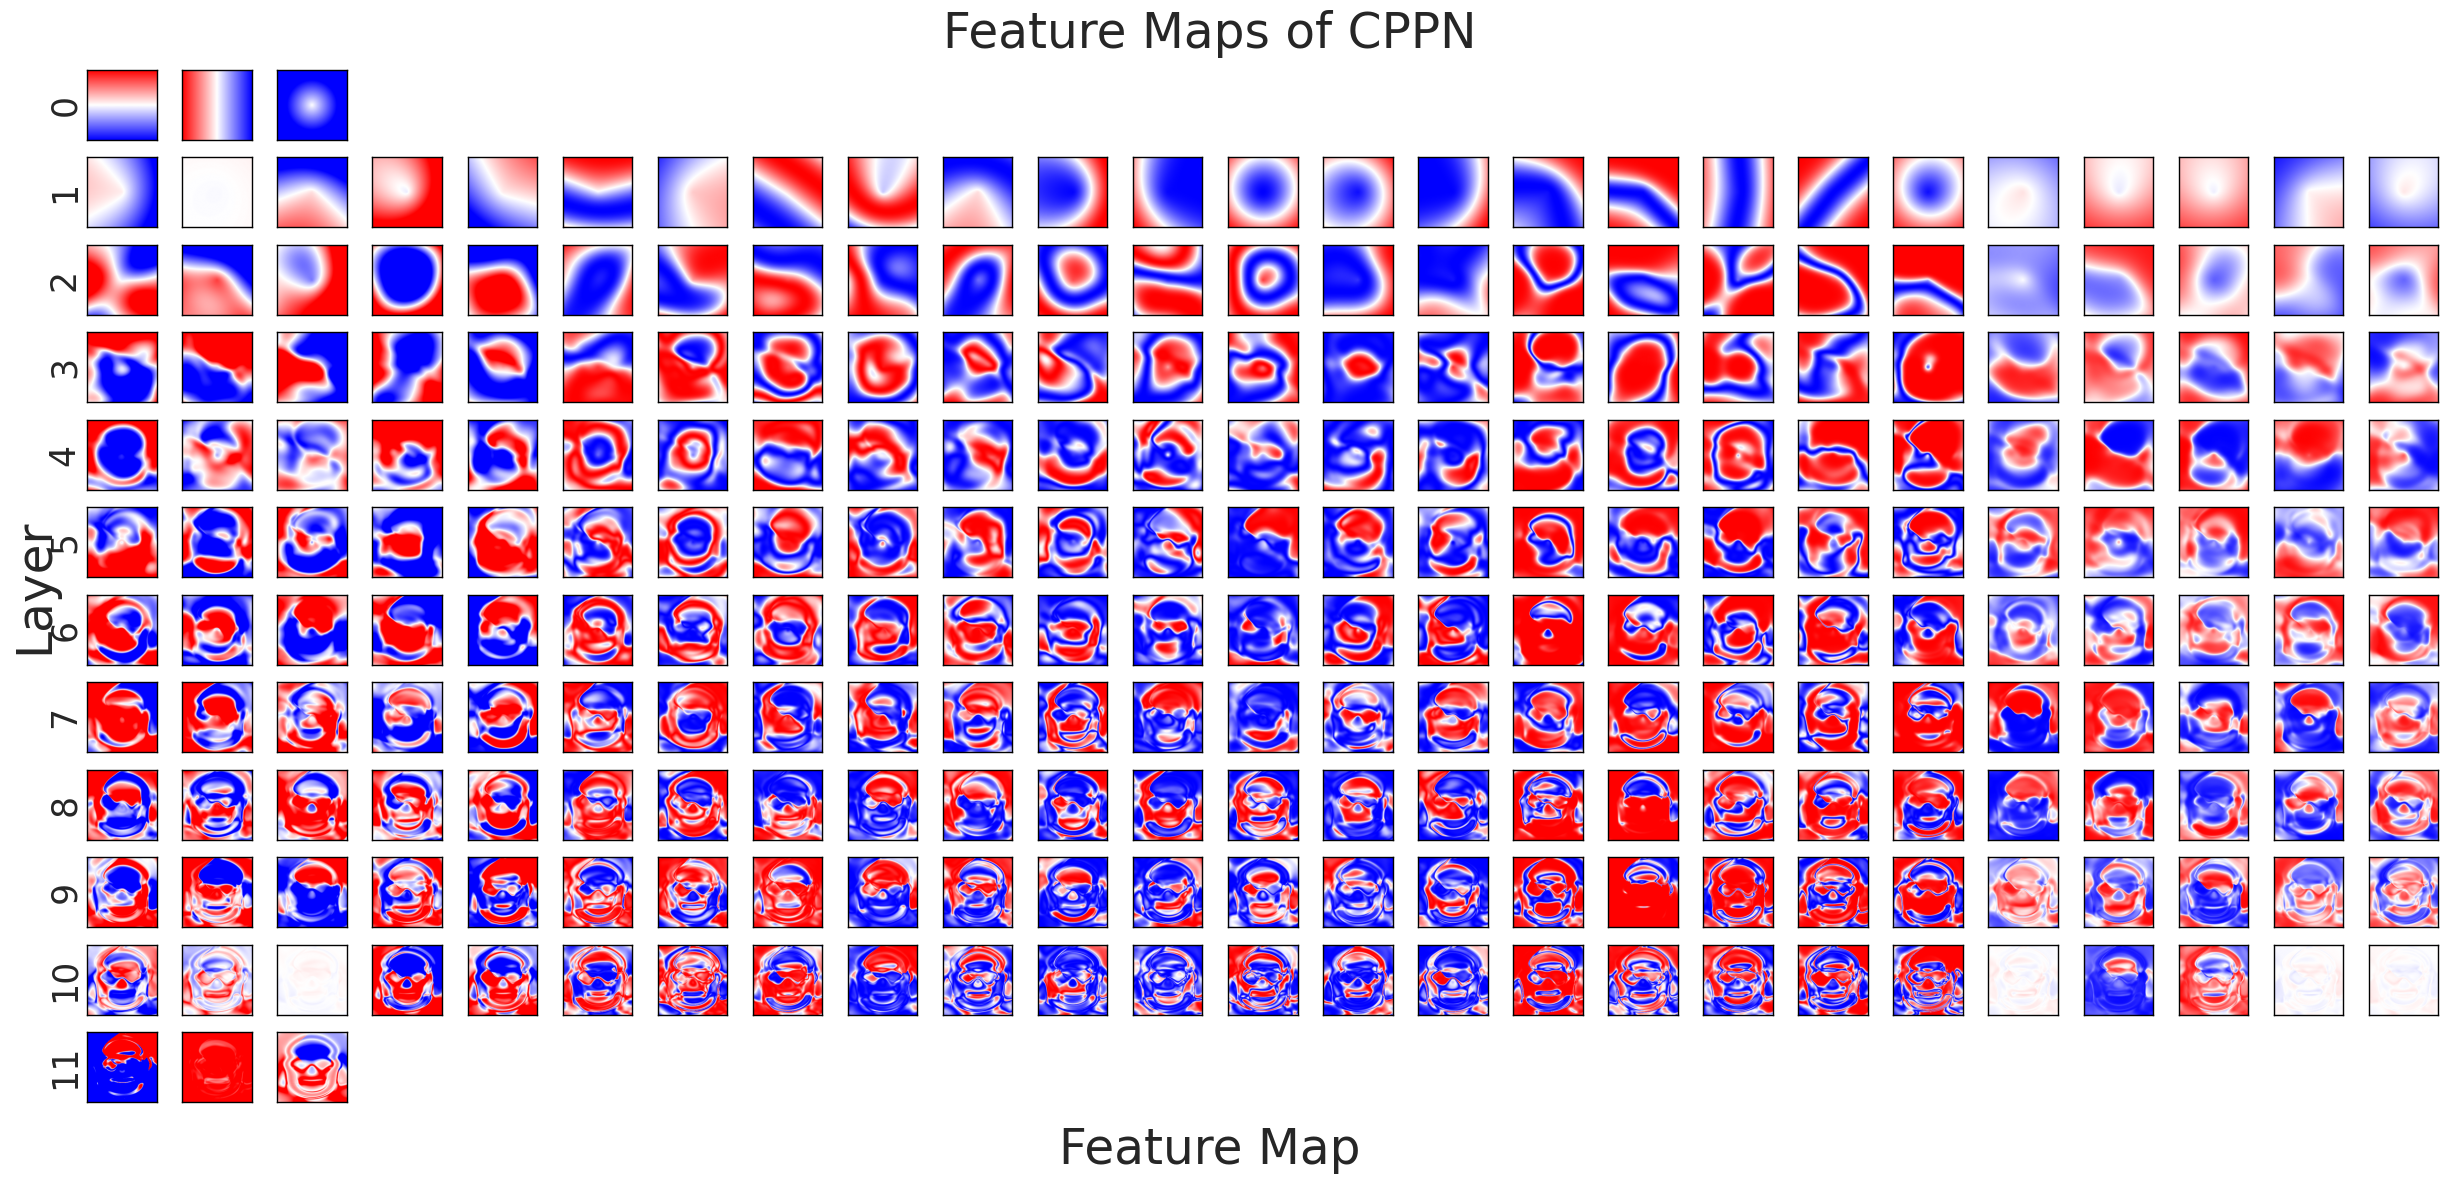

In [77]:
img, features = cppn.generate_image(params, return_features=True)
viz_feature_maps(img, features)
plt.show()

In [85]:
rng = jax.random.PRNGKey(3)
params_pb = jnp.zeros_like(params)
# params_pb = cppn.init(rng)
params_pb = cppn.param_reshaper.reshape_single(params_pb)

In [83]:
params_pb = cppn.param_reshaper.flatten_single(params_pb)

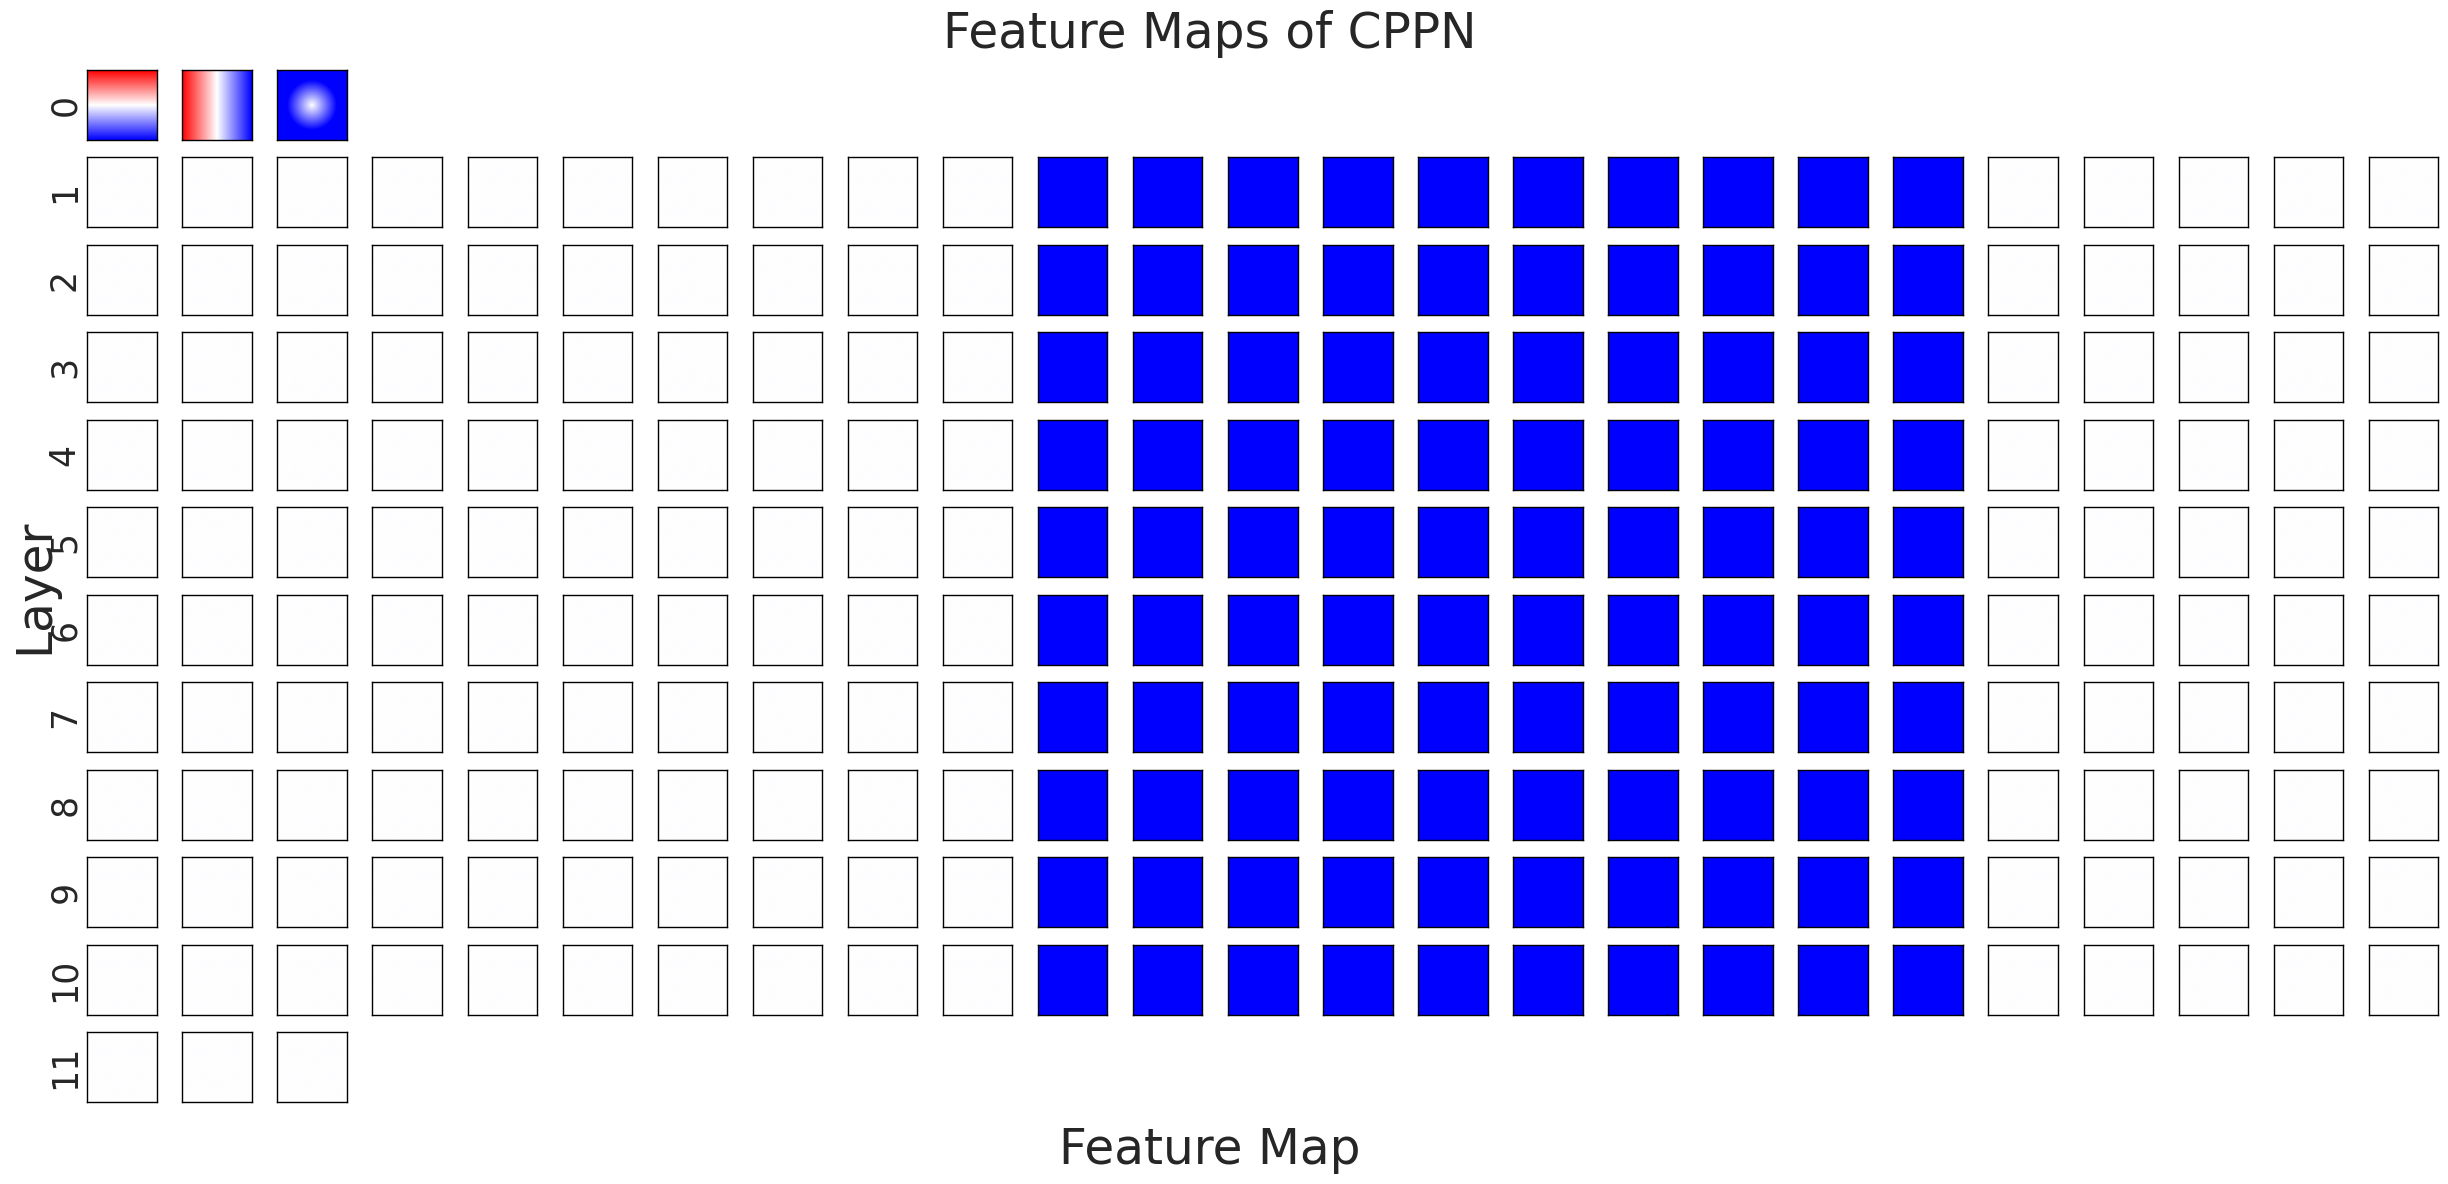

In [84]:
viz_feature_maps(*cppn.generate_image(params_pb, return_features=True))
plt.show()

12 cache:15,gaussian:4,identity:2,sin:1
ParameterReshaper: 5478 parameters detected for optimization.


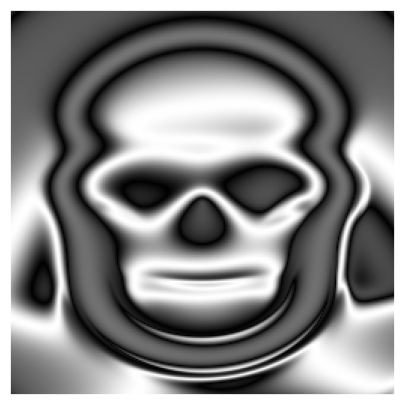

33 cache:28,gaussian:3,sigmoid:5,sin:2
ParameterReshaper: 46474 parameters detected for optimization.


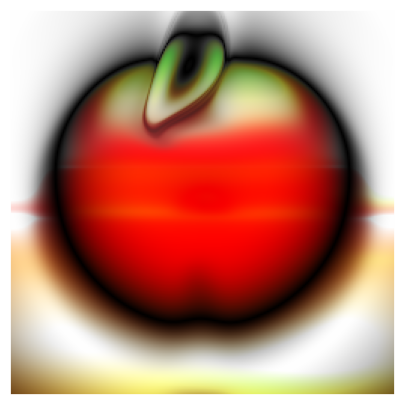

24 cache:18,gaussian:3,identity:2,sigmoid:2,sin:2
ParameterReshaper: 16956 parameters detected for optimization.


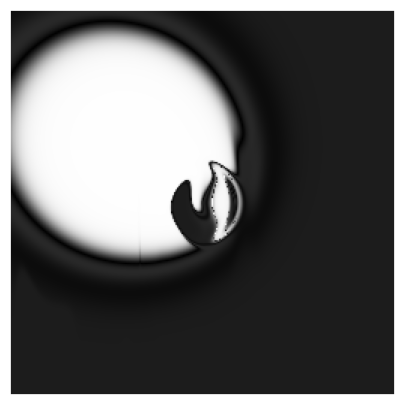

16 cache:17,gaussian:4,sigmoid:1,sin:1
ParameterReshaper: 8096 parameters detected for optimization.


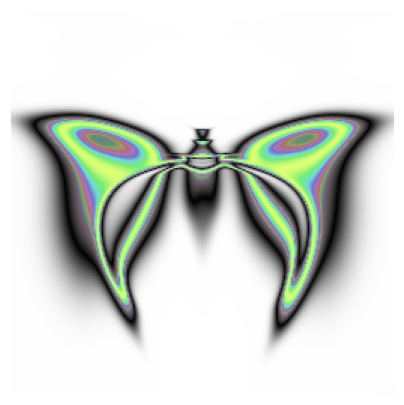

In [14]:
for save_dir in ['../genome_skull', '../genome_apple', '../genome_spotlight', '../genome_butterfly']:
    # save_dir = "../genome_skull"
    pbcppn = util.load_pkl(save_dir, "pbcppn")
    outputs = util.load_pkl(save_dir, "outputs")
    params = util.load_pkl(save_dir, "params")

    nodes_cache = outputs['nodes_cache']
    activation_neurons = outputs['arch']
    n_layers = len(nodes_cache)-1
    cppn = CPPN(n_layers-1, activation_neurons)
    print(n_layers-1, activation_neurons)
    cppn = FlattenCPPNParameters(cppn)

    img, features = cppn.generate_image(params, return_features=True)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.xticks([]); plt.yticks([])
    plt.show()

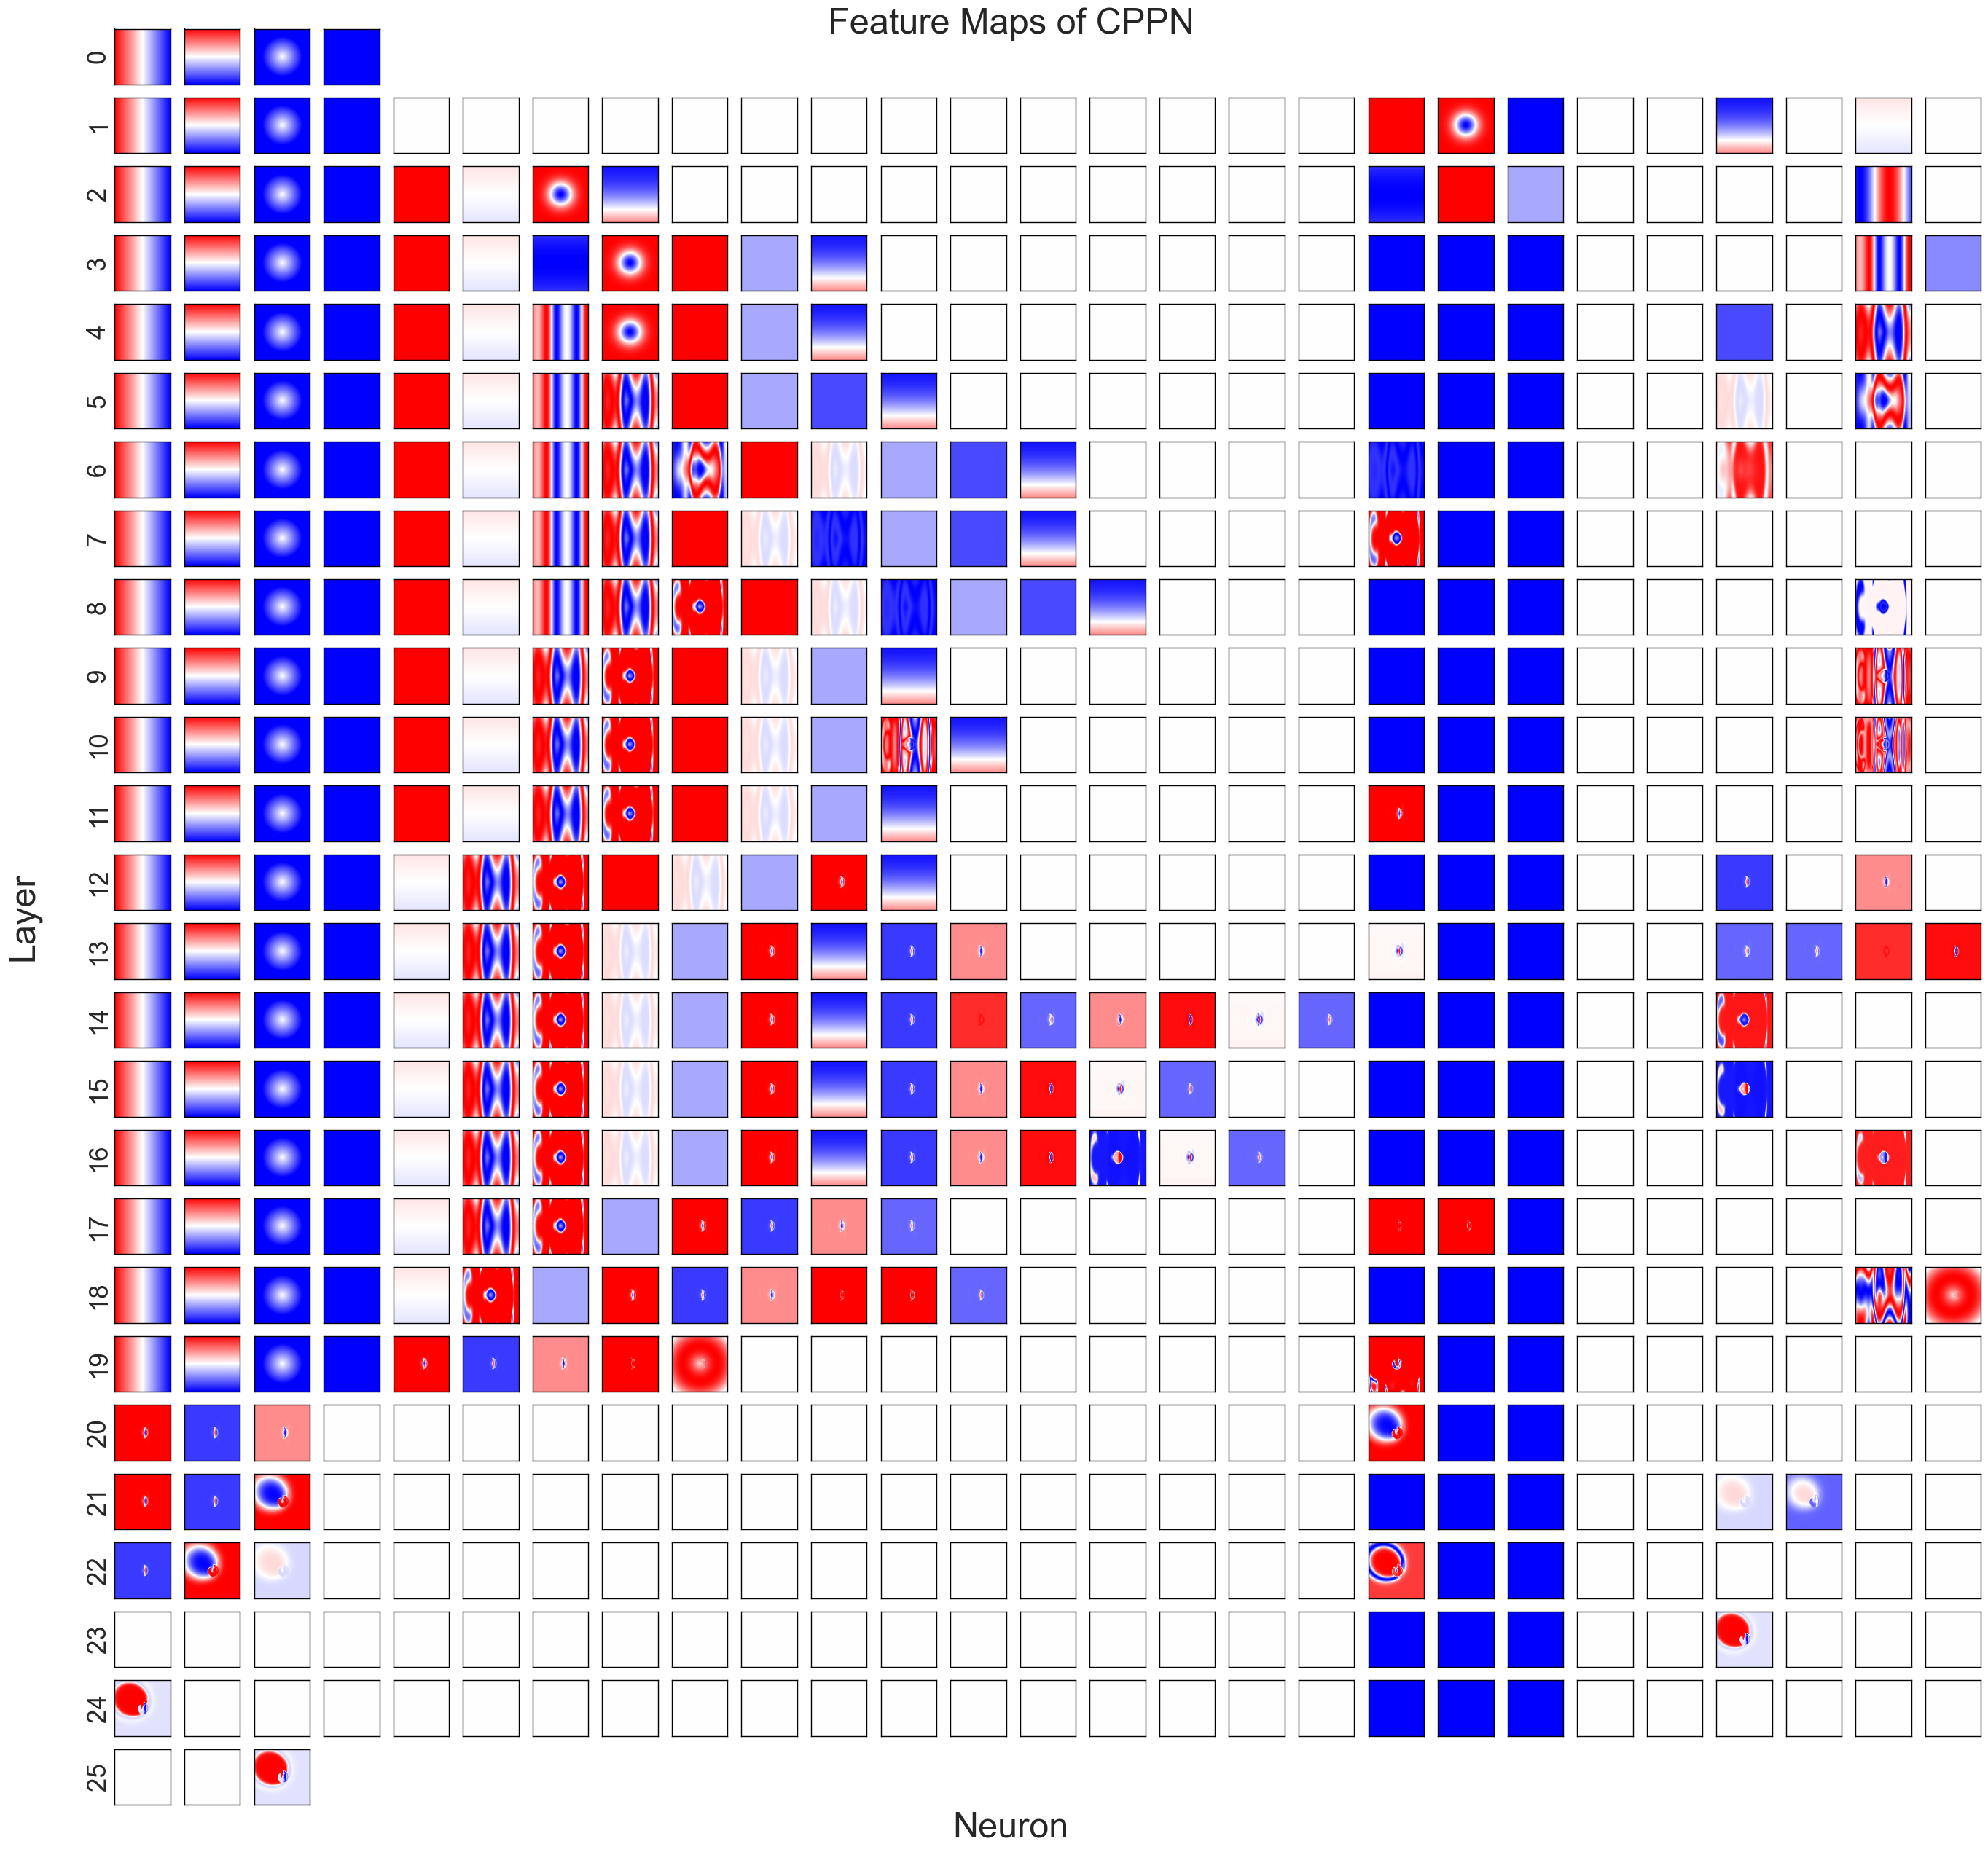

In [8]:
from viz import viz_feature_maps
viz_feature_maps(features)
plt.show()

```bash
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/butterfly/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/butterfly_sgd" --n_layers=16 --arch="cache:17,gaussian:4,sigmoid:1,sin:1" --n_iters=100000 --seed=2
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/butterfly/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/butterfly_sgd_relu" --n_layers=16 --arch="relu:23" --n_iters=100000 --seed=2
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/skull/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/skull_sgd" --n_layers=12 --arch="cache:15,gaussian:4,identity:2,sin:1" --n_iters=100000
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/skull/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/skull_sgd_relu" --n_layers=12 --arch="relu:22" --n_iters=100000
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/apple/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/apple_sgd" --n_layers=33 --arch="cache:28,gaussian:3,sigmoid:5,sin:2" --n_iters=100000
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/apple/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/apple_sgd_relu" --n_layers=33 --arch="relu:38" --n_iters=100000
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/clown/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/clown_sgd" --n_layers=11 --arch="cache:15,gaussian:6,identity:2,sin:1" --n_iters=100000
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/clown/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/clown_sgd_relu" --n_layers=11 --arch="relu:24" --n_iters=100000
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/spotlight/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/spotlight_sgd" --n_layers=24 --arch="cache:18,gaussian:3,identity:2,sigmoid:2,sin:2" --n_iters=100000
python train_sgd_cppn.py --img_file="/home/akarsh_sakana_ai/spaghetti-data/spotlight/img.png" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/spotlight_sgd_relu" --n_layers=24 --arch="relu:27" --n_iters=100000
```

In [ ]:
import train_sgd_cppn

# args = train_sgd_cppn.parse_args('--img_file=/home/akarsh_sakana_ai/spaghetti-data/butterfly/img.png --n_layers=16 --arch=cache:17,gaussian:4,sigmoid:1,sin:1 --n_iters=10000'.split(" "))
args = train_sgd_cppn.parse_args('--img_file=/home/akarsh_sakana_ai/spaghetti-data/butterfly/img.png --n_layers=16 --arch=relu:23 --n_iters=10000'.split(" "))
# args = train_sgd_cppn.parse_args('--seed=2 --img_file=/home/akarsh_sakana_ai/spaghetti-data/butterfly/img.png --n_layers=8 --arch=relu:32 --n_iters=100000'.split(" "))
target_img = jnp.array(plt.imread(args.img_file)[:, :, :3])

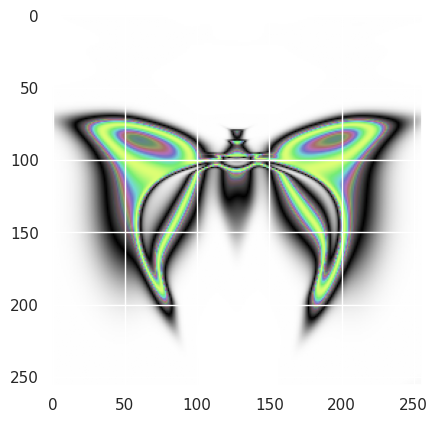

In [13]:
plt.imshow(target_img)

In [14]:
cppn = CPPN(args.n_layers, args.arch)
cppn = FlattenCPPNParameters(cppn)

rng = jax.random.PRNGKey(args.seed)
params = cppn.init(rng)

def loss_fn(params, target_img):
    img = cppn.generate_image(params, img_size=256)
    return jnp.mean((img - target_img)**2)
    # return jnp.mean(jnp.abs(img - target_img))

@jax.jit
def train_step(state, _):
    loss, grad = jax.value_and_grad(loss_fn)(state.params, target_img)
    grad_norm = jnp.linalg.norm(grad)
    grad = grad/grad_norm
    state = state.apply_gradients(grads=grad)
    return state, loss

tx = optax.adam(learning_rate=args.lr)
state = TrainState.create(apply_fn=None, params=params, tx=tx)

gen_img_fn = jax.jit(partial(cppn.generate_image, img_size=256))
losses, imgs_train = [], [gen_img_fn(state.params)]
pbar = tqdm(range(args.n_iters))
for i_iter in pbar:
    # state, loss = jax.lax.scan(train_step, state, None, length=100)
    state, loss = train_step(state, None)
    # print(loss.item())
    img = gen_img_fn(state.params)
    losses.append(loss)
    imgs_train.append(img)

    pbar.set_postfix(loss=loss.mean().item())
losses = np.array(jnp.stack(losses))

ParameterReshaper: 7392 parameters detected for optimization.


  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

(0.0, 0.05)

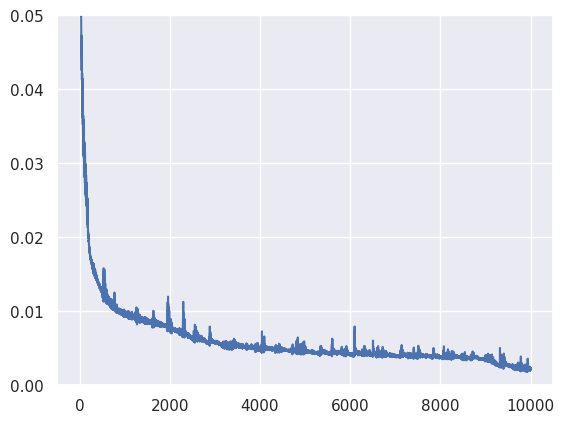

In [ ]:
plt.plot(losses)
plt.ylim(0, .05)

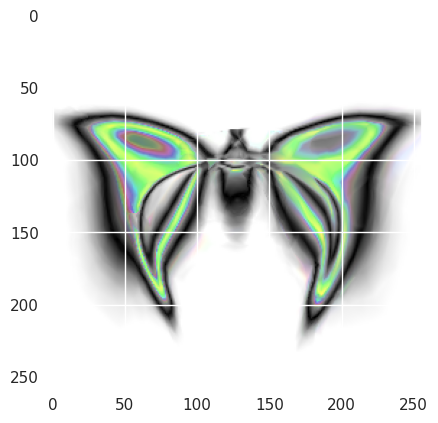

In [ ]:
plt.imshow(img)